command to be able to import modules and have it refresh if they get changed

In [1]:
%load_ext autoreload
%autoreload 2

import our preprocessing fxns, sklearn, pandas and matplotlib.

In [2]:
from ordinal_ranker import *
from fillna import *
import pandas as pd
import numpy as np
import statistics
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn import model_selection as ms
from sklearn import datasets
import matplotlib
from matplotlib import pyplot as plt
plt.style.use('ggplot')
matplotlib.rc('figure', figsize=(6, 6))

read in data.  don't really need sample_submission, but it makes the two files the same shape.  combine them so any transformations, dummifications happen to both.

In [3]:
house_price = pd.read_csv('train.csv')
house_sub = pd.read_csv('test.csv')
sub_ys=pd.read_csv('sample_submission.csv')
house_sub = pd.merge(house_sub,sub_ys,how = 'inner', on = 'Id')
data = pd.concat([house_price, house_sub])

proprocess data with overall fxn made of our fxns

In [4]:
data = data_process(data)

save it because I'm paranoid after we forgot to set the random seed

In [9]:
data.to_csv('cleaned_all_data.csv')

confirm it's the right shape, 180 columns with the sale price

In [10]:
data.shape

(2919, 180)

split apart the big file, the first 1460 points were the training, the rest. the observations that need a predicted price.

In [5]:
train = data.iloc[:house_price.shape[0],:]
sub = data.iloc[house_price.shape[0]:,:]

confirm they're the same number of columns, because I'm paranoid

In [12]:
train.shape,sub.shape

((1460, 180), (1459, 180))

break out the sale price for the train, drop the fake prices for the test set

In [6]:
## separate the predictors and response in the training data set
x_train = np.array(train.drop('SalePrice',axis=1))
y_train = np.ravel(train['SalePrice'])
## separate the predictors and response in the test data set
x_sub = np.array(sub.drop('SalePrice',axis=1))

confirm the training arrays have the same number of row, and 179 columns (because I'm paranoid.)

In [14]:
y_train.shape,x_train.shape

((1460,), (1460, 179))

just confirming, again, that test has 179 columns. still paranoid.

In [15]:
x_sub.shape

(1459, 179)

Notice that there is a serious rightward skew of the sale price, so should take log

(array([148., 723., 373., 135.,  51.,  19.,   4.,   3.,   2.,   2.]),
 array([ 34900., 106910., 178920., 250930., 322940., 394950., 466960.,
        538970., 610980., 682990., 755000.]),
 <a list of 10 Patch objects>)

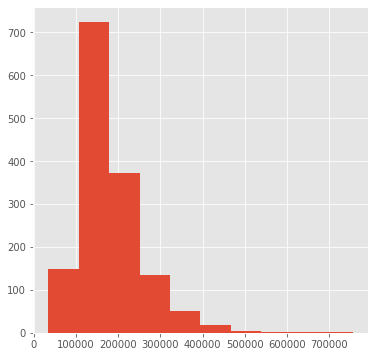

In [16]:
plt.hist(y_train)

much less skew after log transform of data

(array([  5.,  12.,  54., 184., 470., 400., 220.,  90.,  19.,   6.]),
 array([10.46024211, 10.7676652 , 11.07508829, 11.38251138, 11.68993448,
        11.99735757, 12.30478066, 12.61220375, 12.91962684, 13.22704994,
        13.53447303]),
 <a list of 10 Patch objects>)

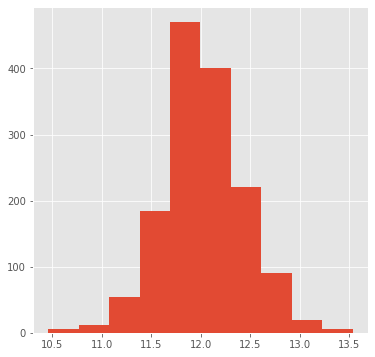

In [7]:
y_train_log = np.log(y_train)
plt.hist(y_train_log)

I tried to use a minmax scaler to scale the features, but it didn't work on some columns for some reason.  fall back on basic method.

In [8]:
x_scaled = (x_train-x_train.min(axis=0))/(x_train.max(axis=0)-x_train.min(axis=0))

In [9]:
x_sub_scaled = (x_sub-x_train.min(axis=0))/(x_train.max(axis=0)-x_train.min(axis=0))

In [16]:
pd.DataFrame(x_sub_scaled)[[3,6,44]].describe()

,3,6,44
count,1459.000000,1459.000000,1459.000000
mean,0.998286,0.561046,0.442426
std,0.046265,0.352174,0.325435
min,-0.250000,0.000000,0.000000
25%,1.000000,0.216667,0.250000
50%,1.000000,0.700000,0.500000
75%,1.000000,0.900000,0.750000
max,1.000000,1.000000,1.000000


In [17]:
pd.DataFrame(x_scaled)[[3,6,44]].describe()

,3,6,44
count,1460.000000,1460.000000,1460.000000
mean,0.999315,0.581096,0.453938
std,0.026171,0.344090,0.332024
min,0.000000,0.000000,0.000000
25%,1.000000,0.283333,0.250000
50%,1.000000,0.733333,0.500000
75%,1.000000,0.900000,0.750000
max,1.000000,1.000000,1.000000


set model from module

In [10]:
svr = SVR()

Here I attempt to do a semi-random cross-validation.  I noticed in the first test_train split that I did all my cross-validation on the set without the serious outlier.  So, I figured I would run multiple splits off a random interger that would set the random state for the split, so random on random. From this I would do a grid_search and pull the best parameters and then get the test r2 from those parameters.  Yes, in a sense I'm looking at my test data, but each model doesn't during cross-validation. Finally I take the median or mode of C and epsilon from the best parameters for each grid_search.

In [44]:
grid_para_svr = [
    {'C': np.linspace(0.025,0.1,8),
     'kernel': ['linear'],
     'epsilon': np.linspace(0.03,0.075,8)}]
espes = []
cs = []
for i in range(100):
    rnint = np.random.randint(0,1000000)
    x_traincv, x_testcv, y_traincv, y_testcv = ms.train_test_split(x_scaled, y_train_log, 
                                                           test_size=0.20, random_state=rnint)
    grid_search_svr = ms.GridSearchCV(svr, grid_para_svr, scoring='r2', cv=5, iid=True, return_train_score=True,  n_jobs=-1)
    grid_search_svr.fit(x_traincv,y_traincv)
    svr.set_params(C= grid_search_svr.best_params_['C'], \
               epsilon = grid_search_svr.best_params_['epsilon'], 
               kernel = 'linear')
    svr.fit(x_traincv,y_traincv)
    cs.append(grid_search_svr.best_params_['C'])
    espes.append(grid_search_svr.best_params_['epsilon'])
    print (rnint, grid_search_svr.best_params_, '%.4f' % svr.score(x_traincv,y_traincv), '%.4f' % svr.score(x_testcv,y_testcv))

/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


830198 {'C': 0.1, 'epsilon': 0.04928571428571428, 'kernel': 'linear'} 0.9167 0.7607


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


70244 {'C': 0.06785714285714287, 'epsilon': 0.03, 'kernel': 'linear'} 0.8908 0.8665


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


725345 {'C': 0.04642857142857143, 'epsilon': 0.075, 'kernel': 'linear'} 0.8816 0.8963


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


218569 {'C': 0.1, 'epsilon': 0.055714285714285716, 'kernel': 'linear'} 0.9136 0.7635


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


717815 {'C': 0.04642857142857143, 'epsilon': 0.055714285714285716, 'kernel': 'linear'} 0.8865 0.8618


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


795923 {'C': 0.03571428571428572, 'epsilon': 0.04285714285714286, 'kernel': 'linear'} 0.8841 0.8708


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


61801 {'C': 0.04642857142857143, 'epsilon': 0.075, 'kernel': 'linear'} 0.8893 0.8635


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


584456 {'C': 0.03571428571428572, 'epsilon': 0.04285714285714286, 'kernel': 'linear'} 0.8891 0.8456


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


564866 {'C': 0.0892857142857143, 'epsilon': 0.06214285714285714, 'kernel': 'linear'} 0.8906 0.8762


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


999833 {'C': 0.04642857142857143, 'epsilon': 0.075, 'kernel': 'linear'} 0.8841 0.8942


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


944895 {'C': 0.05714285714285715, 'epsilon': 0.075, 'kernel': 'linear'} 0.8839 0.8993


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


492390 {'C': 0.1, 'epsilon': 0.075, 'kernel': 'linear'} 0.9136 0.7748


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


455321 {'C': 0.03571428571428572, 'epsilon': 0.055714285714285716, 'kernel': 'linear'} 0.8782 0.9028


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


262529 {'C': 0.0892857142857143, 'epsilon': 0.04285714285714286, 'kernel': 'linear'} 0.9121 0.7828


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


636139 {'C': 0.04642857142857143, 'epsilon': 0.055714285714285716, 'kernel': 'linear'} 0.8899 0.8612


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


532838 {'C': 0.1, 'epsilon': 0.06214285714285714, 'kernel': 'linear'} 0.8958 0.8433


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


146993 {'C': 0.04642857142857143, 'epsilon': 0.055714285714285716, 'kernel': 'linear'} 0.8891 0.8891


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


180631 {'C': 0.03571428571428572, 'epsilon': 0.04928571428571428, 'kernel': 'linear'} 0.8950 0.8327


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


948190 {'C': 0.05714285714285715, 'epsilon': 0.075, 'kernel': 'linear'} 0.8976 0.8264


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


168348 {'C': 0.04642857142857143, 'epsilon': 0.055714285714285716, 'kernel': 'linear'} 0.8826 0.9023


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


711374 {'C': 0.1, 'epsilon': 0.04928571428571428, 'kernel': 'linear'} 0.9126 0.7757


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


837889 {'C': 0.04642857142857143, 'epsilon': 0.06214285714285714, 'kernel': 'linear'} 0.8938 0.8437


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


200878 {'C': 0.04642857142857143, 'epsilon': 0.06214285714285714, 'kernel': 'linear'} 0.8854 0.8995


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


653139 {'C': 0.03571428571428572, 'epsilon': 0.075, 'kernel': 'linear'} 0.8941 0.8413


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


334959 {'C': 0.04642857142857143, 'epsilon': 0.06214285714285714, 'kernel': 'linear'} 0.8854 0.8844


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


388225 {'C': 0.04642857142857143, 'epsilon': 0.04928571428571428, 'kernel': 'linear'} 0.8826 0.8905


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


448524 {'C': 0.1, 'epsilon': 0.06214285714285714, 'kernel': 'linear'} 0.9257 0.6943


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


195474 {'C': 0.1, 'epsilon': 0.075, 'kernel': 'linear'} 0.9158 0.7805


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


214223 {'C': 0.05714285714285715, 'epsilon': 0.06214285714285714, 'kernel': 'linear'} 0.8815 0.9095


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


119850 {'C': 0.05714285714285715, 'epsilon': 0.04285714285714286, 'kernel': 'linear'} 0.8831 0.9020


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


757327 {'C': 0.04642857142857143, 'epsilon': 0.075, 'kernel': 'linear'} 0.8846 0.8925


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


924364 {'C': 0.06785714285714287, 'epsilon': 0.075, 'kernel': 'linear'} 0.8813 0.8930


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


149158 {'C': 0.04642857142857143, 'epsilon': 0.075, 'kernel': 'linear'} 0.8834 0.8841


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


469298 {'C': 0.06785714285714287, 'epsilon': 0.06857142857142856, 'kernel': 'linear'} 0.8954 0.8521


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


384385 {'C': 0.1, 'epsilon': 0.04285714285714286, 'kernel': 'linear'} 0.9192 0.7730


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


598558 {'C': 0.04642857142857143, 'epsilon': 0.055714285714285716, 'kernel': 'linear'} 0.8862 0.8807


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


677025 {'C': 0.03571428571428572, 'epsilon': 0.075, 'kernel': 'linear'} 0.8835 0.8821


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


296898 {'C': 0.1, 'epsilon': 0.04928571428571428, 'kernel': 'linear'} 0.9178 0.7547


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


530257 {'C': 0.05714285714285715, 'epsilon': 0.055714285714285716, 'kernel': 'linear'} 0.8820 0.9098


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


551447 {'C': 0.03571428571428572, 'epsilon': 0.06214285714285714, 'kernel': 'linear'} 0.8791 0.9015


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


241933 {'C': 0.1, 'epsilon': 0.03, 'kernel': 'linear'} 0.9123 0.7843


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


268872 {'C': 0.1, 'epsilon': 0.06857142857142856, 'kernel': 'linear'} 0.9168 0.7478


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


266018 {'C': 0.03571428571428572, 'epsilon': 0.06214285714285714, 'kernel': 'linear'} 0.8770 0.9097


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


893217 {'C': 0.04642857142857143, 'epsilon': 0.04928571428571428, 'kernel': 'linear'} 0.8763 0.9179


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


105694 {'C': 0.1, 'epsilon': 0.055714285714285716, 'kernel': 'linear'} 0.9133 0.7770


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


191567 {'C': 0.07857142857142858, 'epsilon': 0.075, 'kernel': 'linear'} 0.8911 0.8880


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


964180 {'C': 0.03571428571428572, 'epsilon': 0.075, 'kernel': 'linear'} 0.8811 0.9034


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


923927 {'C': 0.025, 'epsilon': 0.04928571428571428, 'kernel': 'linear'} 0.8800 0.8788


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


360109 {'C': 0.0892857142857143, 'epsilon': 0.055714285714285716, 'kernel': 'linear'} 0.9194 0.7473


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


486164 {'C': 0.1, 'epsilon': 0.06214285714285714, 'kernel': 'linear'} 0.9216 0.7448


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


610128 {'C': 0.04642857142857143, 'epsilon': 0.06214285714285714, 'kernel': 'linear'} 0.8821 0.9024


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


226116 {'C': 0.04642857142857143, 'epsilon': 0.06857142857142856, 'kernel': 'linear'} 0.8790 0.9105


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


893850 {'C': 0.04642857142857143, 'epsilon': 0.075, 'kernel': 'linear'} 0.8844 0.8811


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


512384 {'C': 0.04642857142857143, 'epsilon': 0.06857142857142856, 'kernel': 'linear'} 0.8798 0.9064


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


615093 {'C': 0.04642857142857143, 'epsilon': 0.075, 'kernel': 'linear'} 0.8807 0.9126


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


62012 {'C': 0.1, 'epsilon': 0.075, 'kernel': 'linear'} 0.8974 0.8575


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


294490 {'C': 0.04642857142857143, 'epsilon': 0.03642857142857143, 'kernel': 'linear'} 0.8882 0.8617


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


303110 {'C': 0.06785714285714287, 'epsilon': 0.055714285714285716, 'kernel': 'linear'} 0.8826 0.8977


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


839655 {'C': 0.04642857142857143, 'epsilon': 0.06857142857142856, 'kernel': 'linear'} 0.8827 0.8977


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


530529 {'C': 0.05714285714285715, 'epsilon': 0.03, 'kernel': 'linear'} 0.8865 0.8874


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


886931 {'C': 0.03571428571428572, 'epsilon': 0.04285714285714286, 'kernel': 'linear'} 0.8843 0.8775


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


667260 {'C': 0.04642857142857143, 'epsilon': 0.075, 'kernel': 'linear'} 0.8864 0.8806


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


624691 {'C': 0.04642857142857143, 'epsilon': 0.06214285714285714, 'kernel': 'linear'} 0.8921 0.8628


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


354833 {'C': 0.05714285714285715, 'epsilon': 0.06214285714285714, 'kernel': 'linear'} 0.8865 0.8944


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


816693 {'C': 0.03571428571428572, 'epsilon': 0.06214285714285714, 'kernel': 'linear'} 0.8853 0.8765


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


988788 {'C': 0.04642857142857143, 'epsilon': 0.075, 'kernel': 'linear'} 0.8778 0.9215


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


399353 {'C': 0.1, 'epsilon': 0.075, 'kernel': 'linear'} 0.9225 0.7118


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


27622 {'C': 0.03571428571428572, 'epsilon': 0.055714285714285716, 'kernel': 'linear'} 0.8767 0.9140


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


948379 {'C': 0.04642857142857143, 'epsilon': 0.075, 'kernel': 'linear'} 0.8855 0.8843


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


845588 {'C': 0.04642857142857143, 'epsilon': 0.055714285714285716, 'kernel': 'linear'} 0.8828 0.8993


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


795032 {'C': 0.03571428571428572, 'epsilon': 0.06857142857142856, 'kernel': 'linear'} 0.8775 0.9095


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


570236 {'C': 0.04642857142857143, 'epsilon': 0.075, 'kernel': 'linear'} 0.8846 0.8877


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


170744 {'C': 0.04642857142857143, 'epsilon': 0.06214285714285714, 'kernel': 'linear'} 0.8865 0.8783


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


358784 {'C': 0.06785714285714287, 'epsilon': 0.06214285714285714, 'kernel': 'linear'} 0.8855 0.8946


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


478408 {'C': 0.1, 'epsilon': 0.075, 'kernel': 'linear'} 0.9242 0.7487


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


325342 {'C': 0.1, 'epsilon': 0.04285714285714286, 'kernel': 'linear'} 0.9189 0.7512


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


421922 {'C': 0.1, 'epsilon': 0.075, 'kernel': 'linear'} 0.8903 0.8882


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


380672 {'C': 0.1, 'epsilon': 0.04928571428571428, 'kernel': 'linear'} 0.9125 0.7862


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


437307 {'C': 0.05714285714285715, 'epsilon': 0.055714285714285716, 'kernel': 'linear'} 0.8955 0.8496


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


134944 {'C': 0.1, 'epsilon': 0.03642857142857143, 'kernel': 'linear'} 0.9175 0.7647


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


826058 {'C': 0.1, 'epsilon': 0.075, 'kernel': 'linear'} 0.9156 0.7496


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


517084 {'C': 0.04642857142857143, 'epsilon': 0.055714285714285716, 'kernel': 'linear'} 0.8775 0.9151


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


504048 {'C': 0.04642857142857143, 'epsilon': 0.075, 'kernel': 'linear'} 0.8865 0.8889


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


68381 {'C': 0.03571428571428572, 'epsilon': 0.04285714285714286, 'kernel': 'linear'} 0.8889 0.8706


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


529324 {'C': 0.1, 'epsilon': 0.06214285714285714, 'kernel': 'linear'} 0.9110 0.7862


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


695037 {'C': 0.05714285714285715, 'epsilon': 0.04928571428571428, 'kernel': 'linear'} 0.8832 0.8926


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


668143 {'C': 0.025, 'epsilon': 0.06857142857142856, 'kernel': 'linear'} 0.8804 0.8871


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


606673 {'C': 0.03571428571428572, 'epsilon': 0.075, 'kernel': 'linear'} 0.8821 0.8847


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


609930 {'C': 0.1, 'epsilon': 0.075, 'kernel': 'linear'} 0.9234 0.7236


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


292179 {'C': 0.05714285714285715, 'epsilon': 0.055714285714285716, 'kernel': 'linear'} 0.8893 0.8698


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


802667 {'C': 0.03571428571428572, 'epsilon': 0.03642857142857143, 'kernel': 'linear'} 0.8852 0.8662


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


128570 {'C': 0.03571428571428572, 'epsilon': 0.075, 'kernel': 'linear'} 0.8855 0.8803


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


563500 {'C': 0.04642857142857143, 'epsilon': 0.06857142857142856, 'kernel': 'linear'} 0.8900 0.8815


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


134296 {'C': 0.06785714285714287, 'epsilon': 0.06214285714285714, 'kernel': 'linear'} 0.8964 0.8498


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


544969 {'C': 0.1, 'epsilon': 0.04928571428571428, 'kernel': 'linear'} 0.9136 0.7678


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


688671 {'C': 0.1, 'epsilon': 0.075, 'kernel': 'linear'} 0.9161 0.7672


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


578817 {'C': 0.1, 'epsilon': 0.055714285714285716, 'kernel': 'linear'} 0.9121 0.7675


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


182962 {'C': 0.03571428571428572, 'epsilon': 0.055714285714285716, 'kernel': 'linear'} 0.8824 0.8771


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


682081 {'C': 0.03571428571428572, 'epsilon': 0.04285714285714286, 'kernel': 'linear'} 0.8803 0.8938


/Users/doug/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


463480 {'C': 0.04642857142857143, 'epsilon': 0.06857142857142856, 'kernel': 'linear'} 0.8847 0.8928


See there is a left skew of the best Cs, so I ended up taking 0.045

0.04642857142857143


(array([ 2., 19., 33.,  0., 10.,  6.,  0.,  1.,  3., 26.]),
 array([0.025 , 0.0325, 0.04  , 0.0475, 0.055 , 0.0625, 0.07  , 0.0775,
        0.085 , 0.0925, 0.1   ]),
 <a list of 10 Patch objects>)

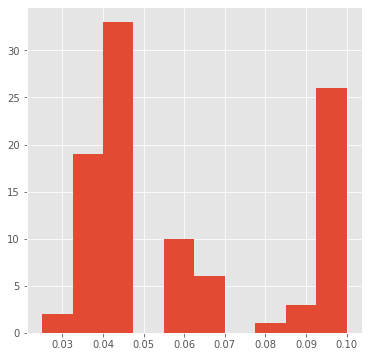

In [45]:
print(statistics.median(cs))
plt.hist(cs)

the epsilons were more normal-ish, so I took the mode at about 0.06.

0.06214285714285714


(array([ 3.,  3.,  9.,  0., 10., 18.,  0., 18.,  9., 30.]),
 array([0.03  , 0.0345, 0.039 , 0.0435, 0.048 , 0.0525, 0.057 , 0.0615,
        0.066 , 0.0705, 0.075 ]),
 <a list of 10 Patch objects>)

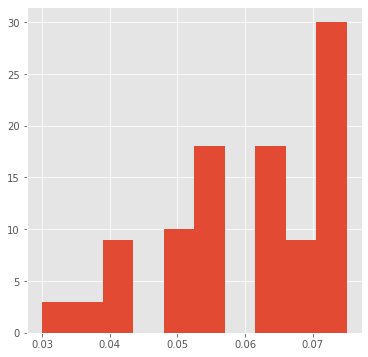

In [46]:
print(statistics.median(espes))
plt.hist(espes)

take the estimates for c and epsilon above and put into another iteration of test_train splits to get an idea of the variance around the r2 for train and test for each random split.  The estimates are about 89% for the average train r2, and 87% for the test r2.

In [48]:
trn_scr=[]
tst_scr=[]
for i in range(8):
    rnint = np.random.randint(0,1000000)
    x_traincv, x_testcv, y_traincv, y_testcv = ms.train_test_split(x_scaled, y_train_log, 
                            test_size=0.20, random_state=rnint)
    svr.set_params(C= 0.045, \
               epsilon = 0.06, 
               kernel = 'linear')
    svr.fit(x_traincv,y_traincv)
    trn_scr.append(svr.score(x_traincv,y_traincv))
    tst_scr.append(svr.score(x_testcv,y_testcv))
    print (rnint,'%.4f' % svr.score(x_traincv,y_traincv), '%.4f' % svr.score(x_testcv,y_testcv))
print()
print('%.4f' % statistics.mean(trn_scr),'%.4f' % statistics.mean(tst_scr))

846692 0.8777 0.9206
144481 0.8831 0.8898
329172 0.8792 0.9159
920239 0.8824 0.9053
774805 0.9093 0.7752
736070 0.9057 0.8060
451501 0.8796 0.8957
866030 0.8888 0.8705

0.8882 0.8724


do one more test train split to get the r2 for the entire train set and entire test set.

In [11]:
# rnint = np.random.randint(0,1000000)
x_traincv, x_testcv, y_traincv, y_testcv = ms.train_test_split(x_scaled, y_train_log, 
                        test_size=0.20, random_state=396462)
svr.set_params(C= 0.045, epsilon = 0.06, kernel = 'linear')
svr.fit(x_traincv,y_traincv)
print ('train r2',396462, '%.4f' % svr.score(x_traincv,y_traincv))
print ('test r2',396462, '%.4f' % svr.score(x_testcv,y_testcv))

train r2 396462 0.8837
test r2 396462 0.8945


get the coefficients for the model.

In [12]:
coefs = list(zip(train.columns[train.columns!='SalePrice'],list(svr.coef_[0])))
srt_coef = sorted(coefs, key=lambda element: (element[0], element[1]))
srt_coef
srt_coef_df = pd.DataFrame(srt_coef)

will plot only those above 0.04 magnitude.

In [24]:
srt_ceoff_high = srt_coef_df[abs(srt_coef_df[1])>0.04]
srt_ceoff_high = srt_ceoff_high.set_index(0)
srt_ceoff_high

,1
0,
BedroomAbvGr,0.168201
BsmtExposure,0.100548
BsmtFinSF1,0.290263
BsmtFinSF2,0.093179
BsmtFinType1,0.048096
...,...
ThreSsnPorch,0.088407
TotalBsmtSF,0.326293
Utilities,0.045000


In [25]:
matplotlib.rc('figure', figsize=(15, 15))

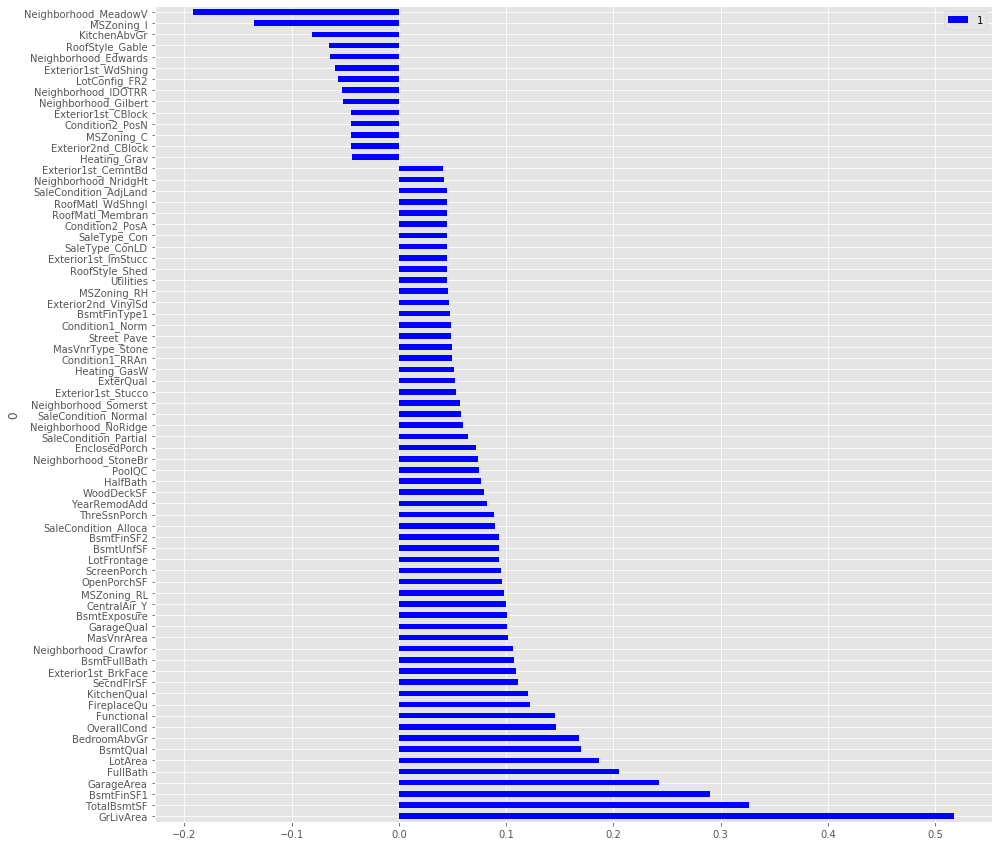

In [26]:
srt_coef_df=pd.DataFrame(srt_coef)
plt.style.use('ggplot')
srt_ceoff_high.sort_values(ascending=False, by = 1).plot.barh(color='b')

In [27]:
matplotlib.rc('figure', figsize=(6, 6))

plot the fitted price vs actual price, notice the exp to get an actual price, not a log

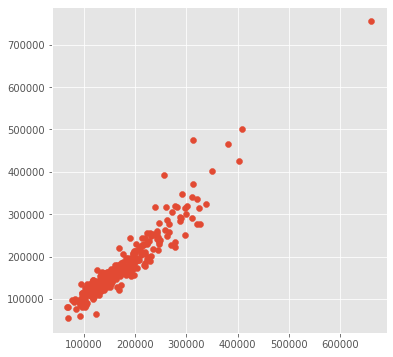

In [28]:
plt.scatter(np.exp(svr.predict(x_testcv)), np.exp(y_testcv))

plot the prediction from the validated parameters against the y_train.  There are a couple of 

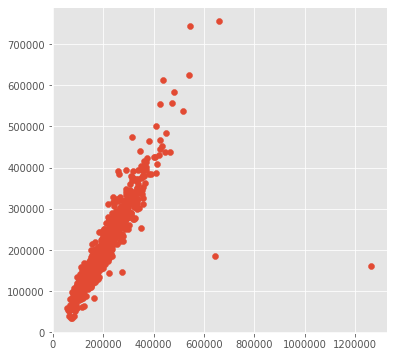

In [29]:
plt.scatter(np.exp(svr.predict(x_scaled)),y_train)

plot the test residuals vs the log of the fitted price

Text(0, 0.5, 'test residual')

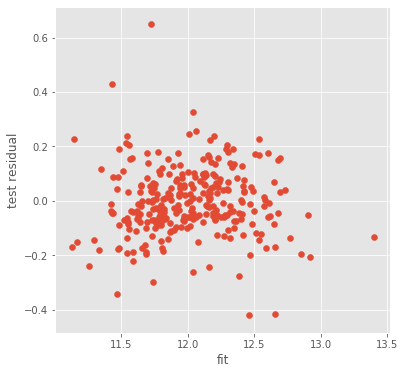

In [30]:
residtest = svr.predict(x_testcv)-y_testcv
plt.scatter(svr.predict(x_testcv), residtest)
plt.xlabel('fit')
plt.ylabel('test residual')

see a little rightward skew of some outliers, but not terrible

(array([  3.,   6.,  40., 119.,  81.,  33.,   8.,   1.,   0.,   1.]),
 array([-0.42170424, -0.31455532, -0.2074064 , -0.10025748,  0.00689144,
         0.11404036,  0.22118928,  0.3283382 ,  0.43548712,  0.54263604,
         0.64978496]),
 <a list of 10 Patch objects>)

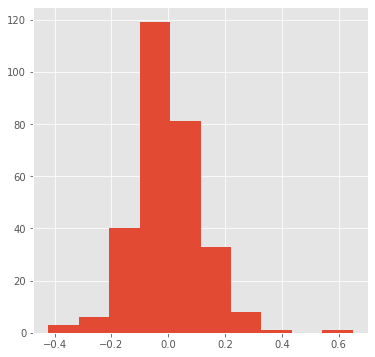

In [31]:
plt.hist(residtest)

plot the train residuals, again notice outliers

Text(0, 0.5, 'train residual')

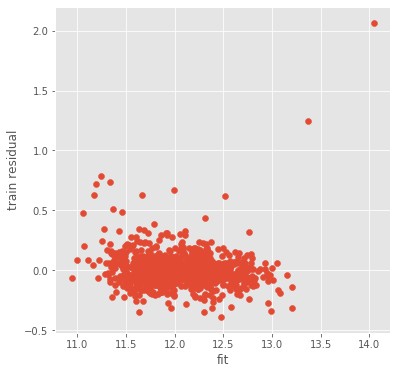

In [32]:
residtrain = svr.predict(x_traincv)-y_traincv
plt.scatter(svr.predict(x_traincv), residtrain)
plt.xlabel('fit')
plt.ylabel('train residual')

(array([ 86., 930., 138.,   5.,   7.,   0.,   1.,   0.,   0.,   1.]),
 array([-0.38821207, -0.14269612,  0.10281983,  0.34833578,  0.59385173,
         0.83936769,  1.08488364,  1.33039959,  1.57591554,  1.82143149,
         2.06694744]),
 <a list of 10 Patch objects>)

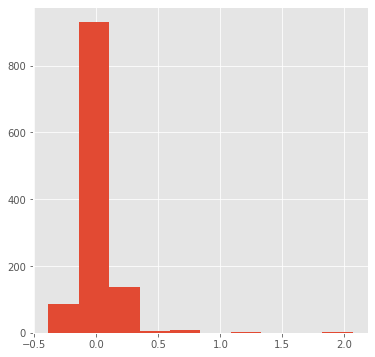

In [33]:
plt.hist(residtrain)

take a look at any autocorrelation in training residuals

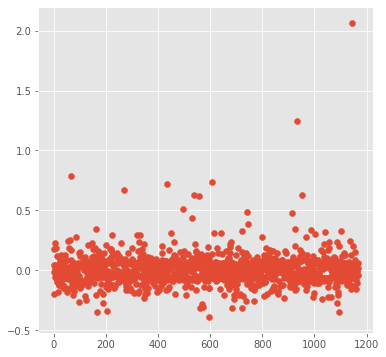

In [34]:
plt.scatter(range(len(residtrain)), residtrain)

same for test residuals

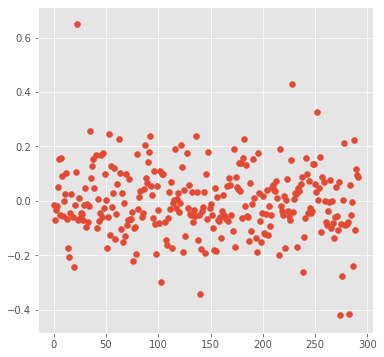

In [35]:
plt.scatter(range(len(residtest)), residtest)

look at effect of C and epsilon on r2 for train and test

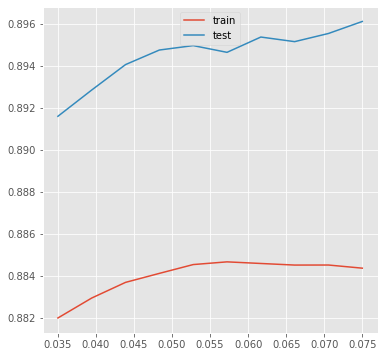

In [62]:
Cs = np.linspace(0.035,0.075,10)
trn_scor=[]
tst_scor=[]
for C in Cs:
    svr.set_params(C= C, epsilon = 0.06, kernel = 'linear')
    svr.fit(x_traincv,y_traincv)
    trn_scor.append(svr.score(x_traincv,y_traincv))
    tst_scor.append(svr.score(x_testcv,y_testcv))
plt.plot(Cs,trn_scor,label='train')
plt.plot(Cs,tst_scor,label='test')
plt.legend(loc=9)

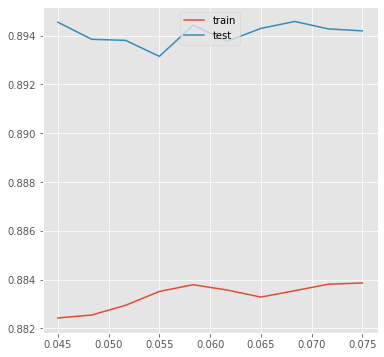

In [63]:
epsilons = np.linspace(0.045,0.075,10)
trn_scor=[]
tst_scor=[]
for epsilon in epsilons:
    svr.set_params(C= 0.045, epsilon = epsilon, kernel = 'linear')
    svr.fit(x_traincv,y_traincv)
    trn_scor.append(svr.score(x_traincv,y_traincv))
    tst_scor.append(svr.score(x_testcv,y_testcv))
plt.plot(epsilons,trn_scor,label='train')
plt.plot(epsilons,tst_scor,label='test')
plt.legend(loc=9)

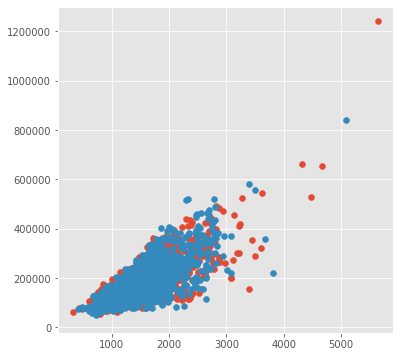

In [65]:
plt.scatter(train['GrLivArea'],np.exp(svr.predict(x_scaled)))
plt.scatter(sub['GrLivArea'],np.exp(svr.predict(x_sub_scaled)))

put scale factor (1/(Max-Min)) for each feature with the feature name and the coefficient.

In [17]:
scale_fctr=[]
for i in range(x_train.shape[1]):
    scale_fctr.append(1/(x_train.max(axis=0)[i]-x_train.min(axis=0)[i]))
coefs_scl = list(zip(train.columns[train.columns!='SalePrice'],list(svr.coef_[0]),scale_fctr))
coefs_dict = pd.DataFrame(coefs_scl).set_index(0).T.to_dict('list')
coefs_dict

{'LotFrontage': [0.10637835880938935, 0.003424657534246575],
 'LotArea': [0.18164603661033868, 4.674098483255042e-06],
 'LotShape': [-0.016566767610054385, 0.06666666666666667],
 'Utilities': [0.04500000000000037, 0.08333333333333333],
 'LandSlope': [0.005350235849479301, 0.125],
 'OverallCond': [0.14925697731247398, 0.0125],
 'YearRemodAdd': [0.08766295145059577, 0.016666666666666666],
 'MasVnrArea': [0.09379810680961624, 0.000625],
 'ExterQual': [0.05745999684065162, 0.047619047619047616],
 'ExterCond': [-0.030814132270400446, 0.041666666666666664],
 'BsmtQual': [0.16297870088715205, 0.02857142857142857],
 'BsmtCond': [-0.0011443171843726618, 0.041666666666666664],
 'BsmtExposure': [0.10313449204773352, 0.041666666666666664],
 'BsmtFinType1': [0.048367687839916074, 0.020833333333333332],
 'BsmtFinSF1': [0.2845546484182367, 0.00017717930545712261],
 'BsmtFinSF2': [0.0933835069326591, 0.0006784260515603799],
 'BsmtUnfSF': [0.09562277801955674, 0.0004280821917808219],
 'TotalBsmtSF': [0

Because we calculated the log of the sales price effects are multiplicative.  exp(Y + DeltaY) where a change in one of the coefficients creates a DeltaY, which is the same as multiplying exp(Y)exp(DeltaY).  So we will find the median price and assume that is the starting point for any changes.  We use the model to calculate the DeltaY from the scaled change in the parameter, raise that as a power of exp, then multiply the median price by the exp(DeltaY) and subtract the median price from that to get the increase due to the change in the parameter.

Median house price is $163,000:

In [37]:
median_price = statistics.median(train['SalePrice'])
median_price

163000.0

Add 500 sq ft (22 foot square) above grade would increase value by (coefficient * scaling factor * addition * price):

In [39]:
print('%.0f' % (np.exp(coefs_dict['GrLivArea'][0]*coefs_dict['GrLivArea'][1]*500)*\
                median_price-median_price))

8140


Adding 200 sq ft of finished basement space (14 foot square) would increase value by:

In [41]:
print('%.0f' % (np.exp(coefs_dict['BsmtFinSF1'][0]*coefs_dict['BsmtFinSF1'][1]*200)*\
                median_price-median_price))

1685


improving kitchen quality from Fair to Good quality would increase value by nearly $9000 but the [ may be comparable:](https://www.manta.com/cost-kitchen-remodeling-des-moines-ia)

In [42]:
print('%.0f' % (np.exp(coefs_dict['KitchenQual'][0]*coefs_dict['KitchenQual'][1]*12)*\
                median_price-median_price))

8993


Adding a full bathroom would increase value by:

In [43]:
print('%.0f' % (np.exp(coefs_dict['FullBath'][0]*coefs_dict['FullBath'][1]*1)*\
                median_price-median_price))

11570


An addition of 150 sq ft (12 foot square) on your garage would increase value by:

In [44]:
print('%.0f' % (np.exp(coefs_dict['GarageArea'][0]*coefs_dict['GarageArea'][1]*150)*\
                median_price-median_price))

4237


improving the overall condition of the house (cleaning, repair, etc) from below average, 4, to above average, 6, would increase value by:

In [45]:
print('%.0f' % (np.exp(coefs_dict['OverallCond'][0]*coefs_dict['OverallCond'][1]*(36-16))*\
                median_price-median_price))

6075


write out sale price predictions for submission set to a csv

In [14]:
test_y_predict = np.exp(svr.predict(x_sub_scaled))

In [33]:
import csv
with open('coefs_dict.csv', 'w') as f:
    for key in coefs_dict.keys():
        f.write("%s,%f8,%f10\n"%(key,coefs_dict[key][0],coefs_dict[key][1]))

In [25]:
np.savetxt("svr_ames_prediction.csv", test_y_predict, delimiter=",")

In [39]:
np.savetxt('svr_ames_prediction.csv', (range(1461,2920),test_y_predict), delimiter=',', header = 'ID, SalePrice')